dat shape (neurons x trials): (39209, 5900)
Evaluated 39209 neurons


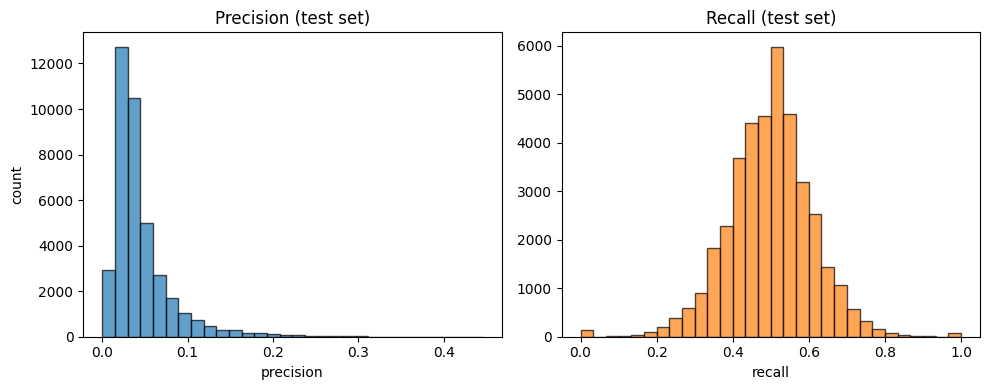

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

# --- load data ---
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']
embeddings = np.stack(list(vit_dict))  # (118, 1000)
X = softmax(embeddings, axis=1)

# --- compute entropy per image ---
eps = 1e-12
entropy = -np.sum(X * np.log(X + eps), axis=1)  # (118,)

# --- basic structure ---
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Expand entropy for each trial
H_trials = np.repeat(entropy, n_trials)  # shape (5900,)

# Split images into train/test without leaking trials
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)

train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# --- convert responses to binary events ---
# you can threshold at, e.g., mean + 1 std, or a fixed small positive threshold
threshold = 0.0
Y_binary = (dat > threshold).astype(int)

# --- fit logistic per neuron ---
precisions, recalls = [], []

for i in range(n_neurons):
    y = Y_binary[i]

    # skip degenerate neurons
    if y.sum() < 10:
        continue

    # split
    y_train, y_test = y[train_mask], y[test_mask]
    X_train, X_test = H_trials[train_mask].reshape(-1, 1), H_trials[test_mask].reshape(-1, 1)

    # fit logistic
    model = LogisticRegression(max_iter=500, class_weight='balanced')
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # metrics
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, zero_division=0))

precisions, recalls = np.array(precisions), np.array(recalls)
print(f"Evaluated {len(precisions)} neurons")

# --- histograms ---
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(precisions, bins=30, color='tab:blue', alpha=0.7, edgecolor='k')
ax[0].set_title("Precision (test set)")
ax[0].set_xlabel("precision")
ax[0].set_ylabel("count")

ax[1].hist(recalls, bins=30, color='tab:orange', alpha=0.7, edgecolor='k')
ax[1].set_title("Recall (test set)")
ax[1].set_xlabel("recall")

plt.tight_layout()
plt.show()


In [11]:
from sklearn.linear_model import LogisticRegression

tjur_R2 = []

for i in range(n_neurons):
    y = Y_binary[i]
    if y.sum() < 10:
        continue

    X_train, X_test = H_trials[train_mask].reshape(-1, 1), H_trials[test_mask].reshape(-1, 1)
    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(max_iter=500, class_weight='balanced')
    model.fit(X_train, y_train)
    p_test = model.predict_proba(X_test)[:, 1]

    R2_tjur = p_test[y_test == 1].mean() - p_test[y_test == 0].mean()
    tjur_R2.append(R2_tjur)


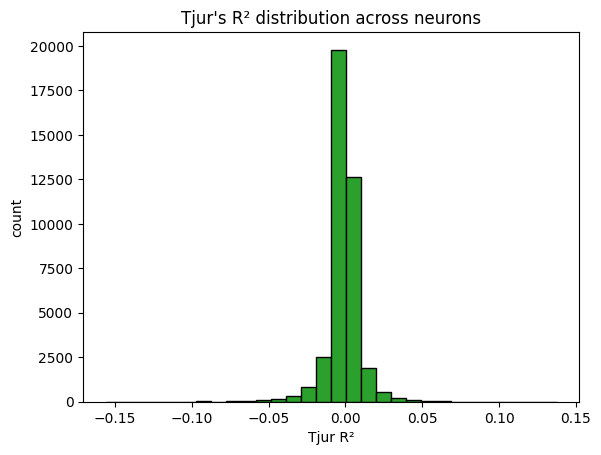

In [12]:
plt.hist(tjur_R2, bins=30, color='tab:green', edgecolor='k')
plt.title("Tjur's R² distribution across neurons")
plt.xlabel("Tjur R²")
plt.ylabel("count")
plt.show()


Evaluated 39209 neurons


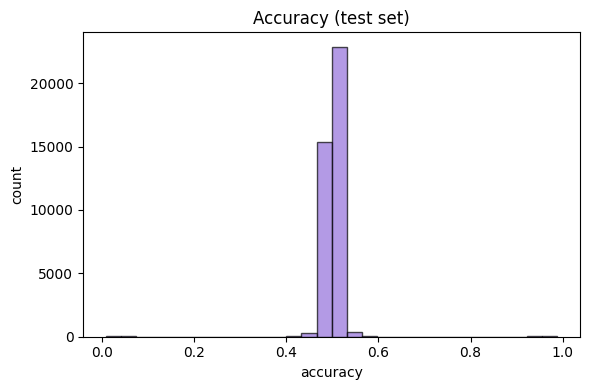

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

accuracies = []

for i in range(n_neurons):
    y = Y_binary[i]
    if y.sum() < 10:  # skip neurons with too few spikes
        continue

    # split by mask (no leakage)
    y_train, y_test = y[train_mask], y[test_mask]
    X_train, X_test = H_trials[train_mask].reshape(-1, 1), H_trials[test_mask].reshape(-1, 1)

    # logistic regression with class balancing
    model = LogisticRegression(max_iter=500, class_weight='balanced')
    model.fit(X_train, y_train)

    # predict on held-out test images
    y_pred = model.predict(X_test)

    # compute accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

accuracies = np.array(accuracies)
print(f"Evaluated {len(accuracies)} neurons")

# --- histogram ---
plt.figure(figsize=(6, 4))
plt.hist(accuracies, bins=30, color='mediumpurple', alpha=0.7, edgecolor='k')
plt.title("Accuracy (test set)")
plt.xlabel("accuracy")
plt.ylabel("count")
plt.tight_layout()
plt.show()


Evaluated 39209 neurons with 1000-D embedding input


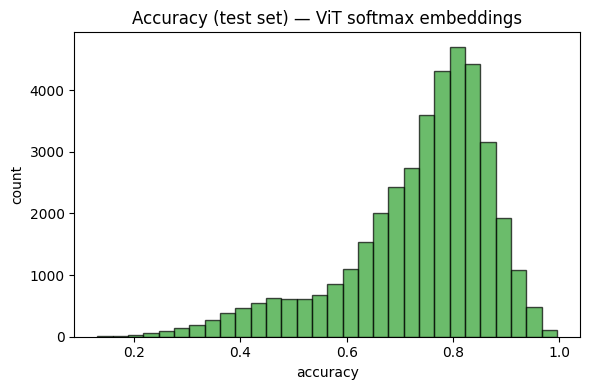

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- expand embeddings for each trial ---
# (118, 1000) → (5900, 1000)
X_trials = np.repeat(X, n_trials, axis=0)

accuracies_embed = []

for i in range(n_neurons):
    y = Y_binary[i]
    if y.sum() < 10:
        continue

    # Split by image-based masks (no leakage)
    X_train, X_test = X_trials[train_mask], X_trials[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Fit logistic regression with L2 regularization and class balance
    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'  # works well for many small fits
    )
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_embed.append(acc)

accuracies_embed = np.array(accuracies_embed)
print(f"Evaluated {len(accuracies_embed)} neurons with 1000-D embedding input")

# --- plot histogram ---
plt.figure(figsize=(6, 4))
plt.hist(accuracies_embed, bins=30, color='tab:green', alpha=0.7, edgecolor='k')
plt.title("Accuracy (test set) — ViT softmax embeddings")
plt.xlabel("accuracy")
plt.ylabel("count")
plt.tight_layout()
plt.show()


(array([1.4895e+04, 1.6427e+04, 4.6990e+03, 1.7750e+03, 7.6600e+02,
        3.9600e+02, 1.7500e+02, 5.9000e+01, 1.4000e+01, 3.0000e+00]),
 array([0.        , 0.05383952, 0.10767903, 0.16151855, 0.21535807,
        0.26919758, 0.3230371 , 0.37687662, 0.43071613, 0.48455565,
        0.53839517]),
 <BarContainer object of 10 artists>)

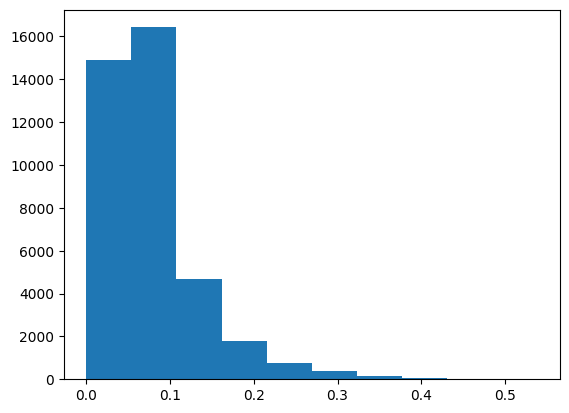

In [10]:
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
plt.hist(f1s)

In [3]:
train_mask

array([False, False, False, ...,  True,  True,  True], shape=(5900,))

In [5]:
precisions

array([0., 0., 0., ..., 0., 0., 0.], shape=(39209,))

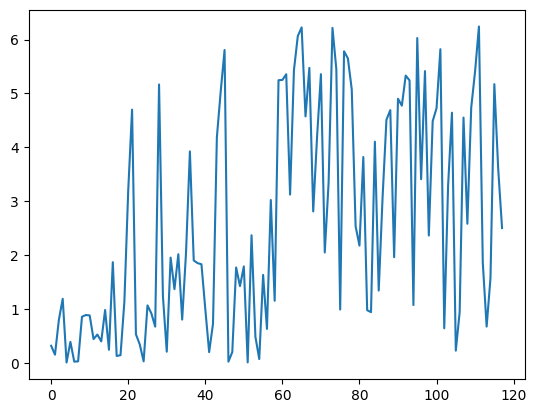

In [6]:
plt.plot(entropy)